Install packages and mount google drive

In [4]:
# Install required packages.
import os
#!pip install --upgrade torch
#!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip3 install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install -q git+https://github.com/pyg-team/pytorch_geometric.git

#!conda install pytorch-scatter -c pyg
#!conda install pytorch-sparse -c pyg
#!conda install pyg -c pyg

#from google.colab import drive

#drive.mount('/content/drive')

#os.chdir('/content/drive/My Drive/MIDS-GNN')

2.3.0+cu121


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
tensor = torch.rand(3, 3).to(device)
print(tensor)

cuda
tensor([[0.4831, 0.9861, 0.1928],
        [0.6212, 0.4516, 0.3388],
        [0.2097, 0.7404, 0.0596]], device='cuda:0')


Initialize dataset

Elapsed time: 0.0080 seconds

Dataset: MIDSdataset(12311):
Number of graphs: 12311
Number of features: 8
Number of classes: 2

Data(edge_index=[2, 26], x=[8, 8], y=[40])
Number of nodes: 8
Number of edges: 26
Average node degree: 3.25
Has isolated nodes: False
Has self-loops: False
Is undirected: True


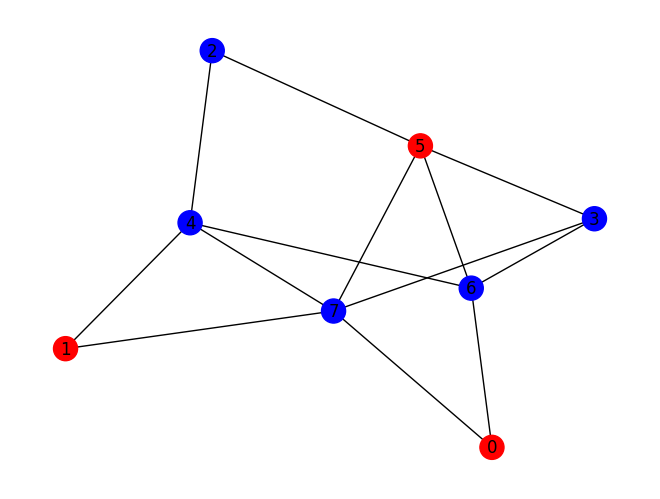

In [3]:
!pip3 install codetiming
%run -i '/home/jovyan/MIDS-GNN/pyg_dataset.py'
#%run -i '/home/jovyan/MIDS_collection/PyTorch Geometric/Dataset/raw_file_snapshot.py'

Load dataset

In [4]:
from pathlib import Path
import os
os.chdir('/home/jovyan/MIDS-GNN')
root ="/home/jovyan/MIDS-GNN/Dataset"

selected_graph_sizes = {3:  -1,
                            4:  -1,
                            5:  -1,
                            6:  -1,
                            7:  -1,
                            8:  -1,
                            9:  100,
                            10: 100}
loader = GraphDataset(selection=selected_graph_sizes)

#import zipfile
#with zipfile.ZipFile('/home/jovyan/MIDS_collection/PyTorch Geometric/Dataset/raw_data.zip', 'r') as zip_ref:
#    zip_ref.extractall('/home/jovyan/MIDS_collection/PyTorch Geometric/Dataset/raw_data')
    
raw_included_subdirs = None

dataset = MIDSdataset(root, loader)

print()
print(f"Dataset: {dataset}:")
print("====================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")


Dataset: MIDSdataset(12311):
Number of graphs: 12311
Number of features: 8
Number of classes: 2


Define GNN structure

In [5]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv

torch.manual_seed(12345)
dataset = dataset.shuffle()

# split dataset into train and test
train_dataset = dataset[:10000]
test_dataset = dataset[10000:]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, 1, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x.squeeze()

Train a model

In [7]:
import os
import torch

from math import inf
import torch.nn.functional as F
from torch import Tensor
from typing import Optional

class CustomLossFunction(torch.nn.BCEWithLogitsLoss):
  def forward(self, input: Tensor, target: Tensor) -> Tensor:
      tens = torch.split(target, input.size(dim=0))[0]
      loss = F.binary_cross_entropy_with_logits(input, tens, self.weight, pos_weight=self.pos_weight, reduction=self.reduction)
      for tens in torch.split(target, input.size(dim=0)):
          new = F.binary_cross_entropy_with_logits(input, tens, self.weight, pos_weight=self.pos_weight, reduction=self.reduction)
          if new.item() < loss.item():
              loss = new
      return loss

from torch_sparse import SparseTensor

def check_MIDS(A, candidate, target_value):
    """
    Args:
        - A: adjacency matrix
        - candidate: node labels that are candidate for MIDS (data.y)
        - target_value: known size of the MIDS
    """
    # TODO: This function needs to be adjusted.
    #   - Instead of adjacency matrix, we may pass the edgelist and convert it here

    n = len(candidate)

    # Candidate set is not minimal
    if sum(candidate) > target_value:
        return False

    # Candidate set is not dominating and independent
    if not all((A + np.eye(n)) @ candidate >= 1):
        return False

    for i in range(n):
        for j in range(i+1, n):
            if candidate[i] and candidate[j] and A[i,j]:
                return False



    if sum(candidate) < target_value:
        print(f"Somehow we found an even smaller MIDS: {sum(candidate)}, {target_value}")
        pass

    return True

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)
#loss_op = torch.nn.CrossEntropyLoss()
#loss_op = torch.nn.BCEWithLogitsLoss()
loss_op = CustomLossFunction()


def train():
    model.train()

    total_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        pred = model(data.x.type(torch.FloatTensor).to(device), data.edge_index)
        real = data.y.type(torch.LongTensor)
        loss = loss_op(pred.to(device), data.y.to(device))

        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    flag = 0
    correct = 0
    correct_checkMIDS = 0
    for i, data in enumerate(loader):
        for idx in range(data.num_graphs):
          out = model(data.get_example(idx).x.type(torch.FloatTensor).to(device), data.get_example(idx).edge_index.to(device))
          #print(out)
          pred = torch.where(out > 0, 1.0, 0.0)
          #print(data.edge_index)

          #correct += int(torch.equal(pred.to(device),data.get_example(idx).y.type(torch.LongTensor).to(device)))  # Derive ratio of correct predictions.

          num_nodes = data.get_example(idx).num_nodes
          adjacency = SparseTensor(row=data.get_example(idx).edge_index[0], col=data.get_example(idx).edge_index[1], sparse_sizes=(num_nodes, num_nodes))
          adjacency_matrix = adjacency.to_dense()
          #print(torch.split(data.get_example(idx).y, data.num_nodes))
          correct_checkMIDS += int(check_MIDS(adjacency_matrix.numpy(),
                                              pred.cpu().numpy(),
                                              sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy())))

    #print(f'{correct_checkMIDS/len(loader.dataset)*100}%')
    return correct_checkMIDS/len(loader.dataset)*100


times = []
losses = []
trains = []
tests = []

for epoch in range(1, 201):
    start = time.time()

    loss = train()
    losses.append(loss)
    if epoch == 1 or epoch % 4 == 0:
      train_f1 = test(train_loader)
      trains.append(train_f1)

      test_f1 = test(test_loader)
      tests.append(test_f1)

      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_f1:.4f}% '
            f'Test: {test_f1:.4f}%, Time: {(time.time() - start):.1f} sec')
    else:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
            f'Time: {(time.time() - start):.1f} sec')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

cuda
1
Epoch: 001, Loss: 0.2011, Train: 68.9000% Test: 68.1523%, Time: 118.1 sec
Epoch: 002, Loss: 0.1597Time: 70.2 sec
Epoch: 003, Loss: 0.1495Time: 69.7 sec
Epoch: 004, Loss: 0.1420, Train: 77.8900% Test: 77.6720%, Time: 116.7 sec
Epoch: 005, Loss: 0.1363Time: 70.2 sec
Epoch: 006, Loss: 0.1309Time: 69.3 sec
Epoch: 007, Loss: 0.1258Time: 69.7 sec
Epoch: 008, Loss: 0.1219, Train: 81.6400% Test: 81.4366%, Time: 116.8 sec
Epoch: 009, Loss: 0.1187Time: 69.5 sec
Epoch: 010, Loss: 0.1142Time: 69.8 sec
Epoch: 011, Loss: 0.1125Time: 69.6 sec
Epoch: 012, Loss: 0.1086, Train: 81.0900% Test: 81.9126%, Time: 116.9 sec
Epoch: 013, Loss: 0.1051Time: 69.7 sec
Epoch: 014, Loss: 0.1021Time: 70.2 sec
Epoch: 015, Loss: 0.0999Time: 69.8 sec
Epoch: 016, Loss: 0.0974, Train: 83.9900% Test: 84.1194%, Time: 116.2 sec
Epoch: 017, Loss: 0.0945Time: 68.9 sec
Epoch: 018, Loss: 0.0918Time: 68.5 sec
Epoch: 019, Loss: 0.0919Time: 69.1 sec
Epoch: 020, Loss: 0.0883, Train: 85.0600% Test: 85.1579%, Time: 113.0 sec
Epo

Plot loss and train and test accuracy

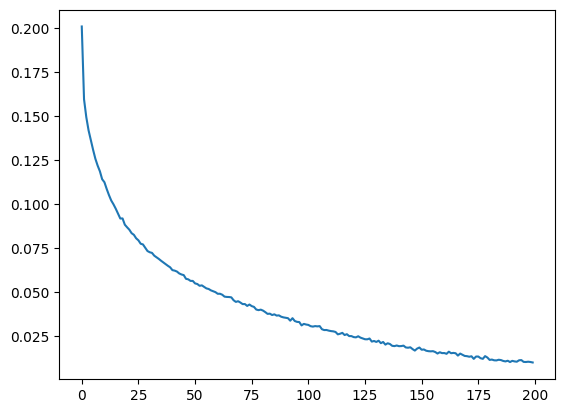

In [8]:
import matplotlib.pyplot as pp
pp.plot(losses)
pp.show()

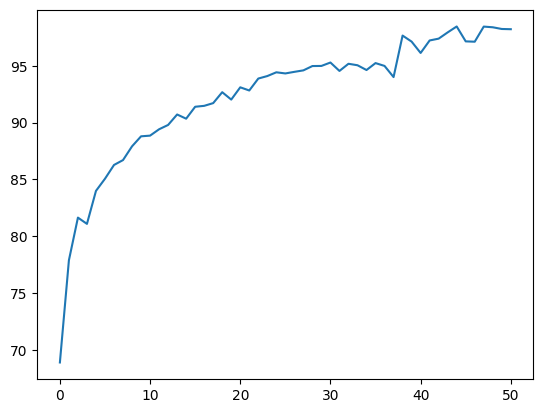

In [9]:
pp.plot(trains)
pp.show()

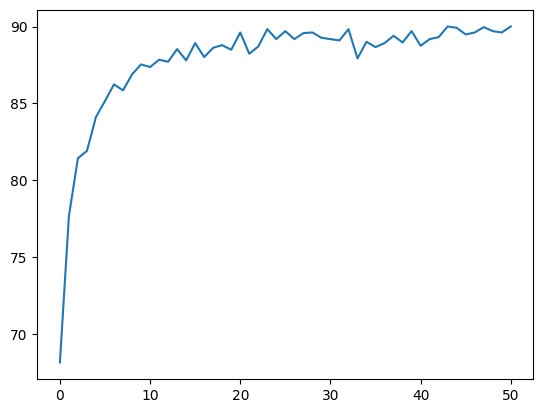

In [10]:
pp.plot(tests)
pp.show()

Save/Load a model

In [13]:
torch.save(model, '/home/jovyan/models/12300_lr-00004_lf-multi_8f.pth')

In [14]:
loaded = torch.load('/home/jovyan/models/12300_lr-00004_lf-multi_8f.pth')

Testing a loaded model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@torch.no_grad()
def test(loader):
    model.eval()
    flag = 0
    correct = 0
    correct_checkMIDS = 0
    for i, data in enumerate(loader):
        for idx in range(data.num_graphs):
          out = model(data.get_example(idx).x.type(torch.FloatTensor).to(device), data.get_example(idx).edge_index.to(device))
          #print(out)
          pred = torch.where(out > 0, 1.0, 0.0)
          #print(data.edge_index)

          #correct += int(torch.equal(pred.to(device),data.get_example(idx).y.type(torch.LongTensor).to(device)))  # Derive ratio of correct predictions.

          num_nodes = data.get_example(idx).num_nodes
          adjacency = SparseTensor(row=data.get_example(idx).edge_index[0], col=data.get_example(idx).edge_index[1], sparse_sizes=(num_nodes, num_nodes))
          adjacency_matrix = adjacency.to_dense()
          correct_checkMIDS += int(check_MIDS(adjacency_matrix.numpy(),
                                              pred.cpu().numpy(),
                                              sum(torch.split(data.get_example(idx).y, data.num_nodes)[0].cpu().numpy())))

    #print(f'{correct_checkMIDS/len(loader.dataset)*100}%')
    return correct_checkMIDS/len(loader.dataset)*100

loader = DataLoader(dataset, batch_size=1, shuffle=False)
test(loader)

96.6696450328974

Visualize wrong predictions

In [21]:
def examine_pred(data, pred):
    G = pygUtils.to_networkx(data, to_undirected=True)
    nx.draw(G, with_labels=True, node_color=pred, cmap=matplotlib.colormaps["bwr"])
    plt.show()
    print(f'prediction: {pred}')
    print(f'data.y:     {data.y.type(torch.LongTensor)}')

for i in range(50):
  d = dataset[i]
  predik = loaded(d.x, d.edge_index).argmax(dim=1)
  if not torch.equal(predik, d.y.type(torch.LongTensor)):
    examine_pred(d, predik)
    print(loaded(d.x, d.edge_index))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)